In [1]:
from qdrant_client import QdrantClient

client = QdrantClient(url="http://localhost:6333")

points = client.retrieve(
    collection_name="log_sessions",
    ids=[0],  # any point id
    with_vectors=True,
    with_payload=True,
)

print("Payload:", points[0].payload)
print("Vector dim:", len(points[0].vector))
print("Vector (first 10):", points[0].vector[:10])

Payload: {'session_id': '00056990-8a66-5ff3-983e-94a5e16dd4b4', 'src_ip': '167.94.138.124', 'tool': 'browser/unknown', 'label': 'suspicious', 'suspicious_score': 0.664872884525143, 'event_count': 3, 'rps': 3.0, 'indicator_hits': 2, 'start_ts': '2023-07-04T16:45:10+00:00', 'end_ts': '2023-07-04T16:45:11+00:00'}
Vector dim: 768
Vector (first 10): [0.025575716, -0.06729195, 0.008444573, 0.07511203, 0.036061034, -0.009445832, -0.047106076, 0.018934302, 0.008608743, -0.027691273]


In [2]:
import numpy as np
from qdrant_client import QdrantClient

client = QdrantClient(url="http://localhost:6333")

# Scroll points (limit for demo)
points, _ = client.scroll(
    collection_name="log_sessions",
    limit=500,  # keep small for t-SNE
    with_vectors=True,
    with_payload=True,
)

X = np.array([p.vector for p in points])
labels = [p.payload.get("label", "unknown") for p in points]

X.shape

(500, 768)

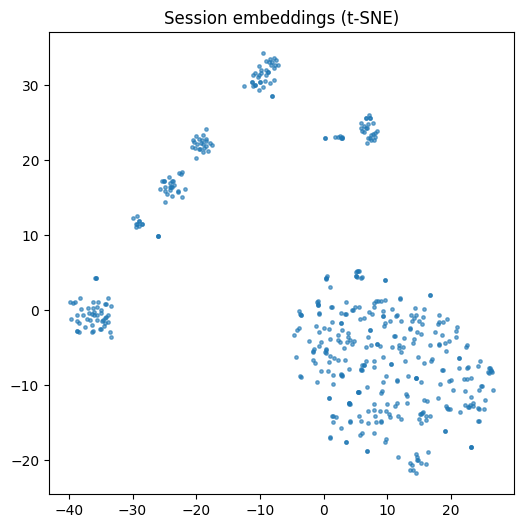

In [3]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

X_2d = TSNE(
    n_components=2, perplexity=30, learning_rate="auto", init="random", random_state=42
).fit_transform(X)

plt.figure(figsize=(6, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], s=6, alpha=0.6)
plt.title("Session embeddings (t-SNE)")
plt.show()

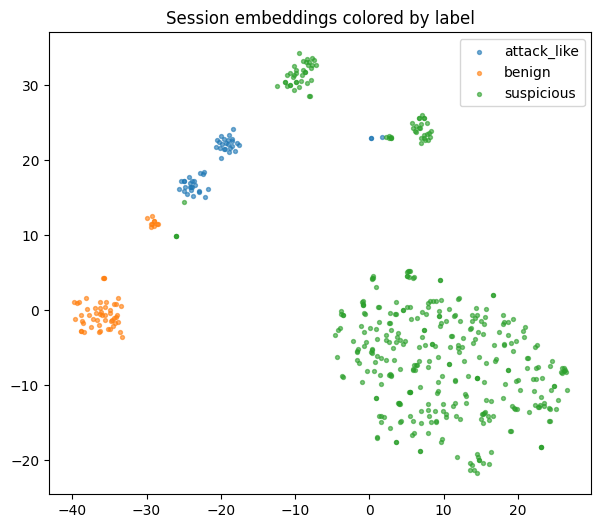

In [4]:
import pandas as pd

df = pd.DataFrame(X_2d, columns=["x", "y"])
df["label"] = labels

plt.figure(figsize=(7, 6))
for lbl, g in df.groupby("label"):
    plt.scatter(g.x, g.y, s=8, alpha=0.6, label=lbl)

plt.legend()
plt.title("Session embeddings colored by label")
plt.show()

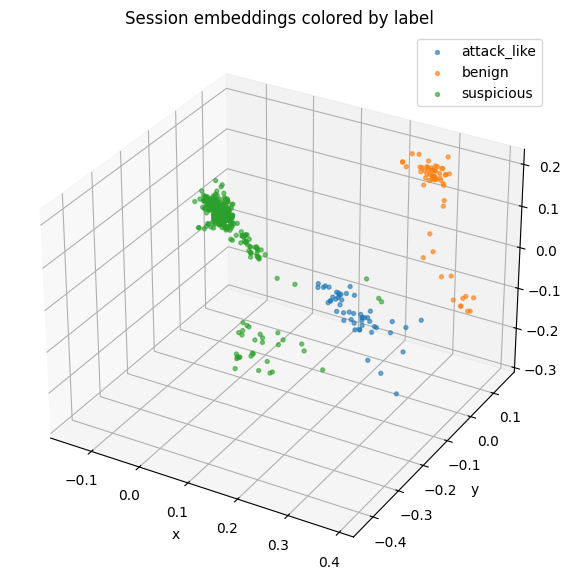

In [5]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from sklearn.decomposition import PCA

# X is your original high‑dim embeddings (e.g., 384 dims)
X_3d = PCA(n_components=3, random_state=42).fit_transform(X)

df = pd.DataFrame(X_3d, columns=["x", "y", "z"])
df["label"] = labels

fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection="3d")

for lbl, g in df.groupby("label"):
    ax.scatter(g.x, g.y, g.z, s=8, alpha=0.6, label=lbl)

ax.set_title("Session embeddings colored by label")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.legend()
plt.show()

In [6]:
client = QdrantClient(url="http://localhost:6333")

cols = client.get_collections().collections
[c.name for c in cols]
for name in ["mitre_attack", "log_sessions"]:
    info = client.get_collection(name)
    print(
        name, "| points:", info.points_count, "| vectors:", info.config.params.vectors
    )

mitre_attack | points: 835 | vectors: size=768 distance=<Distance.COSINE: 'Cosine'> hnsw_config=None quantization_config=None on_disk=None datatype=None multivector_config=None
log_sessions | points: 12097 | vectors: size=768 distance=<Distance.COSINE: 'Cosine'> hnsw_config=None quantization_config=None on_disk=None datatype=None multivector_config=None


In [7]:
# run attack
from src.rag.retrieve import search_attack_for_text

hits = search_attack_for_text(
    "directory brute force enumeration gobuster scanning",
    top_k=10,
    embed_model="sentence-transformers/all-mpnet-base-v2",
    device="auto",
)

for h in hits[:10]:
    p = h.payload
    print(
        f"{h.score:.3f}  {p['technique_id']}  {p['name']}  tactics={p.get('tactics')}"
    )

d:\VScode\isea-rag-attack-classification\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🔧 Embeddings device: cpu


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 588.90it/s, Materializing param=pooler.dense.weight]                        
MPNetModel LOAD REPORT from: sentence-transformers/all-mpnet-base-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Batches: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


0.478  T1083  File and Directory Discovery  tactics=['discovery']
0.471  T1595.003  Wordlist Scanning  tactics=['reconnaissance']
0.423  T1564.001  Hidden Files and Directories  tactics=['defense-evasion']
0.386  T1039  Data from Network Shared Drive  tactics=['collection']
0.385  T1564.012  File/Path Exclusions  tactics=['defense-evasion']
0.383  T1158  Hidden Files and Directories  tactics=['defense-evasion', 'persistence']
0.371  T1005  Data from Local System  tactics=['collection']
0.354  T1560.001  Archive via Utility  tactics=['collection']
0.343  T1087  Account Discovery  tactics=['discovery']
0.343  T1596.005  Scan Databases  tactics=['reconnaissance']


In [8]:
import pandas as pd
from src.rag.retrieve import search_sessions

hits = search_sessions(
    "etc passwd traversal lfi attempt",
    top_k=10,
    label="attack_like",  # try "suspicious" too
    tool="gobuster",  # or None
    embed_model="sentence-transformers/all-mpnet-base-v2",
    device="auto",
)

rows = []
for h in hits:
    p = h.payload
    rows.append(
        {
            "score": round(h.score, 3),
            "session_id": p.get("session_id"),
            "src_ip": p.get("src_ip"),
            "label": p.get("label"),
            "tool": p.get("tool"),
            "suspicious_score": p.get("suspicious_score"),
            "event_count": p.get("event_count"),
            "start_ts": p.get("start_ts"),
        }
    )

pd.DataFrame(rows)

🔧 Embeddings device: cpu


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 540.49it/s, Materializing param=pooler.dense.weight]                        
MPNetModel LOAD REPORT from: sentence-transformers/all-mpnet-base-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Batches: 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


,score,session_id,src_ip,label,tool,suspicious_score,event_count,start_ts
0,0.183,09c5c188-4589-5a34-9ce6-2029e7e1c8a8,152.58.35.2,attack_like,gobuster,0.886938,2,2024-01-30T11:09:16+00:00
1,0.183,87588c17-001a-5f95-9ca1-f710eb33c276,152.58.39.17,attack_like,gobuster,0.886938,2,2024-01-19T02:34:06+00:00
2,0.182,1e5d31e9-50bd-54a1-85fe-e2df078ab6ff,152.58.34.93,attack_like,gobuster,0.886938,2,2024-01-30T07:53:39+00:00
3,0.174,040cce28-ec86-509f-a3cc-5a3142b750e2,152.58.39.230,attack_like,gobuster,0.886938,2,2024-01-19T02:34:38+00:00
4,0.159,d9a0d430-4385-554e-999d-04622b5d9209,49.34.106.190,attack_like,gobuster,0.883937,8,2023-01-09T10:04:12+00:00
5,0.148,fead1d1b-9bde-528b-a63b-c77e622d97ae,152.58.39.168,attack_like,gobuster,0.992743,4591,2024-01-19T02:36:46+00:00
6,0.147,be3405bd-c209-5e03-a323-794631393568,152.58.60.21,attack_like,gobuster,0.990296,1459,2024-01-19T06:27:39+00:00
7,0.146,3a576a07-b534-532c-82c2-e102a99a6b31,152.58.35.97,attack_like,gobuster,0.989026,259021,2024-02-09T05:05:51+00:00
8,0.145,9635a65f-5fb3-5828-a1f2-f3046494cd90,152.58.34.14,attack_like,gobuster,0.990280,9196,2024-01-30T07:53:46+00:00
9,0.144,3e315dc2-d944-5c4b-ac1b-5b68b4ae3bad,152.58.60.21,attack_like,gobuster,0.983720,20444,2024-01-19T06:05:26+00:00


In [9]:
pt = client.retrieve(
    collection_name="log_sessions", ids=[0], with_vectors=True, with_payload=True
)[0]

print("payload:", pt.payload)
print("vector_dim:", len(pt.vector))
print("vector_head:", pt.vector[:8])

payload: {'session_id': '00056990-8a66-5ff3-983e-94a5e16dd4b4', 'src_ip': '167.94.138.124', 'tool': 'browser/unknown', 'label': 'suspicious', 'suspicious_score': 0.664872884525143, 'event_count': 3, 'rps': 3.0, 'indicator_hits': 2, 'start_ts': '2023-07-04T16:45:10+00:00', 'end_ts': '2023-07-04T16:45:11+00:00'}
vector_dim: 768
vector_head: [0.025575716, -0.06729195, 0.008444573, 0.07511203, 0.036061034, -0.009445832, -0.047106076, 0.018934302]


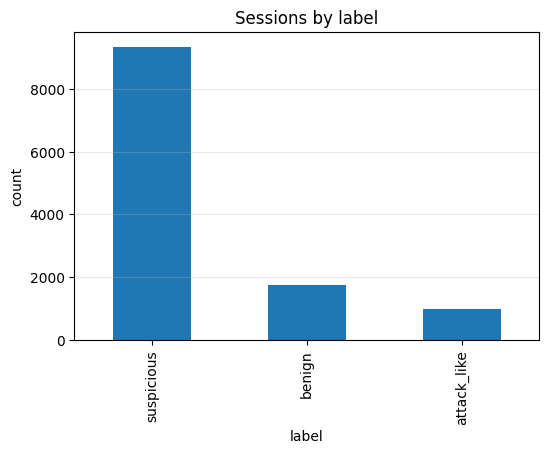

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

s = pd.read_parquet("../data/processed/sessions_scored.parquet")
vc = s["label"].value_counts()

plt.figure(figsize=(6, 4))
vc.plot(kind="bar")
plt.title("Sessions by label")
plt.ylabel("count")
plt.grid(axis="y", alpha=0.3)
plt.show()

In [11]:
from src.rag.retrieve import search_attack_for_text
import pandas as pd

s = pd.read_parquet("../data/processed/sessions_scored.parquet")
row = s[s["label"].isin(["attack_like", "suspicious"])].iloc[0]  # pick one

query = f"""
src_ip={row.src_ip} tool={row.tool} label={row.label}
event_count={row.event_count} rps={row.rps} indicator_hits={row.indicator_hits}
reasons={row.get('rule_reasons', [])}
"""

hits = search_attack_for_text(
    query, top_k=8, embed_model="sentence-transformers/all-mpnet-base-v2", device="auto"
)
[(round(h.score, 3), h.payload["technique_id"], h.payload["name"]) for h in hits]

🔧 Embeddings device: cpu


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 714.34it/s, Materializing param=pooler.dense.weight]                        
MPNetModel LOAD REPORT from: sentence-transformers/all-mpnet-base-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Batches: 100%|██████████| 1/1 [00:00<00:00,  8.12it/s]


[(0.398, 'T1054', 'Indicator Blocking'),
 (0.396, 'T1001.001', 'Junk Data'),
 (0.395, 'T1016.001', 'Internet Connection Discovery'),
 (0.394, 'T1059.006', 'Python'),
 (0.392, 'T1654', 'Log Enumeration'),
 (0.381, 'T1007', 'System Service Discovery'),
 (0.378, 'T1055', 'Process Injection'),
 (0.377, 'T1518.001', 'Security Software Discovery')]